In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### 1. Dataset Klasörünün Kontrolü
Bu adımda Kaggle ortamına eklediğimiz "Brain Tumor MRI Dataset" klasörünün doğru şekilde yüklendiğini kontrol ediyoruz.`/kaggle/input` altında hangi klasörler var ve bizim datasetimiz hangi klasörde tutuluyor onu görüyoruz.

In [1]:
import os
base = '/kaggle/input'
print("base içerikleri:", os.listdir(base))

# otomatik dataset seçimi (adında 'brain' veya 'tumor' geçen ilk klasörü alır)
candidates = [d for d in os.listdir(base) if ('brain' in d.lower()) or ('tumor' in d.lower())]
if len(candidates)==0:
    raise ValueError("Dataset otomatik bulunamadı. /kaggle/input içeriğini kontrol et.")
DATA_DIR = os.path.join(base, candidates[0])
print("Seçilen dataset klasörü:", DATA_DIR)


base içerikleri: ['brain-tumor-mri']
Seçilen dataset klasörü: /kaggle/input/brain-tumor-mri


### 2. Gerekli Kütüphaneler ve Sabitlerin Tanımlanması
Bu hücrede TensorFlow, Keras, scikit-learn ve veri işleme için gerekli kütüphaneleri içe aktarıyoruz.
Ayrıca eğitim için rastgelelikten kaçınmak amacıyla sabit bir `seed` değeri veriyoruz.
Görüntü boyutu (`IMG_SIZE`), batch size ve epoch sayısını belirliyoruz.

In [2]:
# 2) İthalatlar ve sabitler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import random
import tensorflow as tf
#warnings.filterwarnings('ignore')

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

# sabitler
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

IMG_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 10

print("TensorFlow sürüm:", tf.__version__)
print("GPU fiziksel cihazlar:", tf.config.list_physical_devices('GPU'))
# Eğer GPU görünmüyorsa notebook Settings -> Accelerator: GPU yap.


2025-09-23 22:24:24.006729: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758666264.183190      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758666264.246621      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow sürüm: 2.18.0
GPU fiziksel cihazlar: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### 3. Dataset Yapısını İnceleme
Dataset klasörünün iç yapısını kontrol ediyoruz. Çoğu zaman resimler `Training` ve `Testing` alt klasörlerinde bulunur. Bu adımda asıl resimlerin bulunduğu klasörü `MAIN_DIR` olarak belirliyoruz.

In [4]:
for root, dirs, files in os.walk(DATA_DIR):
    print(root, " - alt klasör sayısı:", len(dirs), "dosya sayısı:", len(files))

# yaygın isimlere göre Training klasörünü seç
possible = ['Training','training','Train','train']
MAIN_DIR = None
for p in possible:
    path = os.path.join(DATA_DIR, p)
    if os.path.isdir(path):
        MAIN_DIR = path
        break

# fallback: eğer Training yoksa DATA_DIR'yi ana klasör olarak kullan
if MAIN_DIR is None:
    MAIN_DIR = DATA_DIR
print("Ana resim klasörü (MAIN_DIR):", MAIN_DIR)
print("İçerik (ilk 10):", os.listdir(MAIN_DIR)[:10])

/kaggle/input/brain-tumor-mri  - alt klasör sayısı: 2 dosya sayısı: 0
/kaggle/input/brain-tumor-mri/Training  - alt klasör sayısı: 4 dosya sayısı: 0
/kaggle/input/brain-tumor-mri/Training/pituitary  - alt klasör sayısı: 0 dosya sayısı: 1457
/kaggle/input/brain-tumor-mri/Training/notumor  - alt klasör sayısı: 0 dosya sayısı: 1595
/kaggle/input/brain-tumor-mri/Training/meningioma  - alt klasör sayısı: 0 dosya sayısı: 1339
/kaggle/input/brain-tumor-mri/Training/glioma  - alt klasör sayısı: 0 dosya sayısı: 1321
/kaggle/input/brain-tumor-mri/Testing  - alt klasör sayısı: 4 dosya sayısı: 0
/kaggle/input/brain-tumor-mri/Testing/pituitary  - alt klasör sayısı: 0 dosya sayısı: 300
/kaggle/input/brain-tumor-mri/Testing/notumor  - alt klasör sayısı: 0 dosya sayısı: 405
/kaggle/input/brain-tumor-mri/Testing/meningioma  - alt klasör sayısı: 0 dosya sayısı: 306
/kaggle/input/brain-tumor-mri/Testing/glioma  - alt klasör sayısı: 0 dosya sayısı: 300
Ana resim klasörü (MAIN_DIR): /kaggle/input/brain-tum

### 4. Görüntülerin Yol ve Etiketlerini DataFrame Haline Getirme
Her bir görüntünün dosya yolunu ve sınıf etiketini çıkararak bir DataFrame oluşturuyoruz.
Bu sayede resimler ile etiketlerini kolayca eşleştirebiliriz.

In [5]:
image_paths = []
labels = []

for cls in sorted(os.listdir(MAIN_DIR)):
    cls_path = os.path.join(MAIN_DIR, cls)
    if os.path.isdir(cls_path):
        for fname in os.listdir(cls_path):
            if fname.lower().endswith(('.png','.jpg','.jpeg')):
                image_paths.append(os.path.join(cls_path, fname))
                labels.append(cls)

df = pd.DataFrame({'filepath': image_paths, 'label': labels})
print("Toplam görüntü:", len(df))
if len(df)==0:
    raise ValueError("Görüntü bulunamadı. MAIN_DIR yolunu kontrol et:", MAIN_DIR)
print(df['label'].value_counts())
df.head()

Toplam görüntü: 5712
label
notumor       1595
pituitary     1457
meningioma    1339
glioma        1321
Name: count, dtype: int64


,filepath,label
0,/kaggle/input/brain-tumor-mri/Training/glioma/...,glioma
1,/kaggle/input/brain-tumor-mri/Training/glioma/...,glioma
2,/kaggle/input/brain-tumor-mri/Training/glioma/...,glioma
3,/kaggle/input/brain-tumor-mri/Training/glioma/...,glioma
4,/kaggle/input/brain-tumor-mri/Training/glioma/...,glioma


### 5. Train / Validation / Test Ayrımı
Veri setini %70 eğitim, %15 doğrulama ve %15 test olacak şekilde ayırıyoruz.`stratify` parametresiyle sınıf dağılımlarının korunmasını sağlıyoruz.

In [7]:
train_df, temp_df = train_test_split(df, test_size=0.30, stratify=df['label'], random_state=SEED)
val_df, test_df  = train_test_split(temp_df, test_size=0.50, stratify=temp_df['label'], random_state=SEED)

print("train:", len(train_df), "val:", len(val_df), "test:", len(test_df))
print("train class counts:\n", train_df['label'].value_counts())

train: 3998 val: 857 test: 857
train class counts:
 label
notumor       1116
pituitary     1020
meningioma     937
glioma         925
Name: count, dtype: int64


### 6. Data Augmentation ve Generator'lar
Keras `ImageDataGenerator` sınıfı ile veri artırma (augmentation) işlemleri uyguluyoruz.Bu sayede model daha çeşitli örnekler görerek daha iyi genelleştirme yapabiliyor.

In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='filepath', y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=True
)

val_gen = val_datagen.flow_from_dataframe(
    val_df, x_col='filepath', y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

test_gen = test_datagen.flow_from_dataframe(
    test_df, x_col='filepath', y_col='label',
    target_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE,
    class_mode='categorical', shuffle=False
)

print("Sınıf indeksi (label->index):", train_gen.class_indices)
num_classes = len(train_gen.class_indices)
print("num_classes =", num_classes)

Found 3998 validated image filenames belonging to 4 classes.
Found 857 validated image filenames belonging to 4 classes.
Found 857 validated image filenames belonging to 4 classes.
Sınıf indeksi (label->index): {'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}
num_classes = 4


### 7. Class Weight Hesaplama (Opsiyonel)
Eğer bazı sınıflar çok az örneğe sahipse modelin dengesiz öğrenmesini önlemek için her sınıfa ağırlık hesaplıyoruz.

In [9]:
classes = np.unique(train_df['label'])
cw_values = compute_class_weight('balanced', classes=classes, y=train_df['label'])
class_weights = { train_gen.class_indices[cls]: w for cls, w in zip(classes, cw_values) }
print("class_weights:", class_weights)

class_weights: {0: 1.0805405405405406, 1: 1.0667022411953042, 2: 0.8956093189964157, 3: 0.9799019607843137}


### 8. EfficientNetB0 ile Transfer Learning Modeli
EfficientNetB0 tabanlı bir model oluşturuyoruz. Önceden ImageNet üzerinde eğitilmiş ağı donduruyor ve üstüne yeni katmanlar ekleyerek bizim datasetimize uyum sağlıyoruz.

In [10]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(num_classes, activation='softmax')(x)   # DÜZELTME: num_classes kullanıldı

model = Model(inputs=base_model.input, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


I0000 00:00:1758666513.615228      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 224, 224,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 225, 225,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 112, 112,  │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 112, 112,  │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 112, 112,  │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 112, 112,  │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │        512 │ block1a_se_excit

 Total params: 4,214,055 (16.08 MB)

 Trainable params: 164,484 (642.52 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

### 9. Callbacks Tanımlama
Modelin en iyi versiyonunu kaydetmek, erken durdurma (overfitting'i önlemek) ve öğrenme oranını dinamik değiştirmek için callback fonksiyonlarını ekliyoruz.

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early = EarlyStopping(monitor='val_accuracy', patience=6, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

### 10. Modeli Eğitme
Modeli `train_gen` ile eğitip `val_gen` üzerinde doğrulama yapıyoruz.

In [17]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[checkpoint, early, reduce_lr],
    # class_weight=class_weights  # eğer dengesizlik varsa aktif et
)

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step - accuracy: 0.2515 - loss: 1.3946
Epoch 1: val_accuracy improved from -inf to 0.25554, saving model to best_model.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 81s 324ms/step - accuracy: 0.2515 - loss: 1.3946 - val_accuracy: 0.2555 - val_loss: 1.3860 - learning_rate: 1.0000e-04
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.2785 - loss: 1.3890
Epoch 2: val_accuracy did not improve from 0.25554
250/250 ━━━━━━━━━━━━━━━━━━━━ 52s 209ms/step - accuracy: 0.2785 - loss: 1.3890 - val_accuracy: 0.2345 - val_loss: 1.3865 - learning_rate: 1.0000e-04
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.2489 - loss: 1.3925
Epoch 3: val_accuracy improved from 0.25554 to 0.29522, saving model to best_model.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 53s 213ms/step - accuracy: 0.2489 - loss: 1.3925 - val_accuracy: 0.2952 - val_loss: 1.3826 - learning_rate: 1.0000e-04
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.2642

### 11. Eğitim Sürecinin Görselleştirilmesi
Accuracy ve loss değerlerini epoch bazında çizerek modelin öğrenme durumunu inceliyoruz.

**Overfitting / Underfitting Analizi**
Eğitim ve doğrulama doğruluk/loss grafiklerini yorumluyoruz:

* Eğer eğitim doğruluğu yüksek, doğrulama düşükse → Overfitting (ezberleme).
* Eğer ikisi de düşükse → Underfitting (yetersiz öğrenme).
* Eğer ikisi de yüksek ve birbirine yakınsa → İyi genelleme.

**Accuracy (Doğruluk) grafiği:** Modelin doğru tahmin oranını gösterir.

**Loss (Kayıp) grafiği:** Modelin ne kadar hata yaptığını gösterir (daha düşük = daha iyi).

**SONUÇ:**
1. Overfitting yok → çünkü train ve validation eğrileri birbirine yakın.
2. Model yavaş öğreniyor → accuracy düşük, bu yüzden daha fazla epoch eğitmek veya modeli geliştirmek gerekebilir.
3. İyiye gidiş var → loss değerlerinin düzenli düşmesi, modelin zamanla daha iyi hale geldiğini gösteriyor.

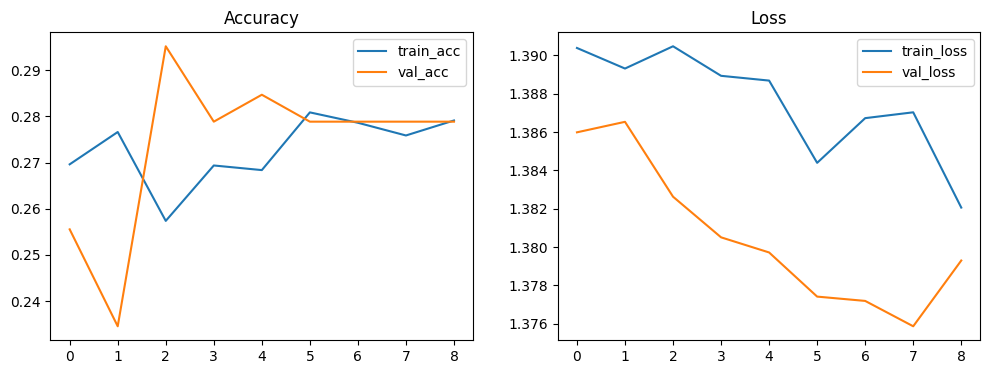

In [19]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history.get('accuracy', []), label='train_acc')
plt.plot(history.history.get('val_accuracy', []), label='val_acc')
plt.title('Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history.get('loss', []), label='train_loss')
plt.plot(history.history.get('val_loss', []), label='val_loss')
plt.title('Loss')
plt.legend()
plt.show()

### 12. Fine-Tuning
Önceden dondurduğumuz taban modelin son katmanlarını açarak daha düşük bir öğrenme oranı ile yeniden eğitiyoruz.

In [24]:
base_model.trainable = True
for layer in base_model.layers[:-20]:
    layer.trainable = False

model.compile(optimizer=Adam(learning_rate=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

fine_epochs = 5
total_epochs = EPOCHS + fine_epochs

fine_history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1] if len(history.epoch)>0 else 0,
    callbacks=[checkpoint, early, reduce_lr],
    # class_weight=class_weights
)

Epoch 9/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.2688 - loss: 1.3898
Epoch 9: val_accuracy improved from 0.29522 to 0.41424, saving model to best_model.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 109s 302ms/step - accuracy: 0.2688 - loss: 1.3898 - val_accuracy: 0.4142 - val_loss: 1.3620 - learning_rate: 1.0000e-05
Epoch 10/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.2849 - loss: 1.3749
Epoch 10: val_accuracy improved from 0.41424 to 0.44574, saving model to best_model.h5
250/250 ━━━━━━━━━━━━━━━━━━━━ 53s 211ms/step - accuracy: 0.2849 - loss: 1.3749 - val_accuracy: 0.4457 - val_loss: 1.3438 - learning_rate: 1.0000e-05
Epoch 11/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step - accuracy: 0.3107 - loss: 1.3602
Epoch 11: val_accuracy did not improve from 0.44574
250/250 ━━━━━━━━━━━━━━━━━━━━ 53s 210ms/step - accuracy: 0.3108 - loss: 1.3601 - val_accuracy: 0.4446 - val_loss: 1.3237 - learning_rate: 1.0000e-05
Epoch 12/15
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step - accurac

### 13. Test Seti Değerlendirmesi
Test verileri üzerinde modelin performansını ölçüyoruz.Confusion matrix ve classification report ile sonuçları görselleştiriyoruz.

54/54 ━━━━━━━━━━━━━━━━━━━━ 20s 219ms/step
              precision    recall  f1-score   support

      glioma       0.81      0.07      0.12       198
  meningioma       0.00      0.00      0.00       201
     notumor       0.92      0.60      0.73       240
   pituitary       0.32      0.99      0.48       218

    accuracy                           0.44       857
   macro avg       0.51      0.42      0.33       857
weighted avg       0.53      0.44      0.35       857



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


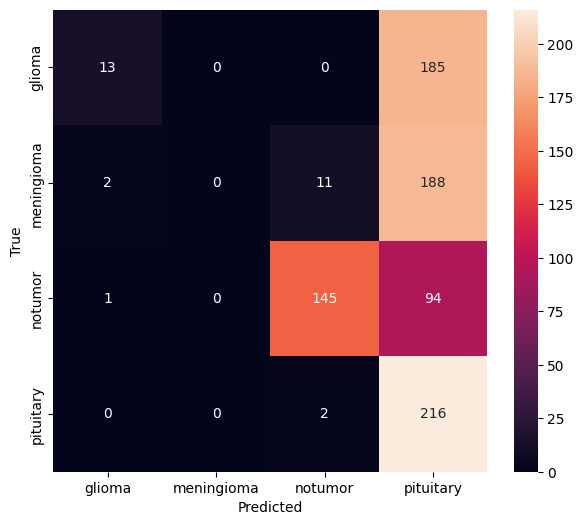

In [25]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

test_steps = int(np.ceil(test_gen.n / test_gen.batch_size))
preds = model.predict(test_gen, steps=test_steps, verbose=1)
y_pred = np.argmax(preds, axis=1)
y_true = test_gen.classes

# label map: index -> label
label_map = {v:k for k,v in train_gen.class_indices.items()}
target_names = [ label_map[i] for i in range(len(label_map)) ]

print(classification_report(y_true, y_pred, target_names=target_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(7,6))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted'); plt.ylabel('True'); plt.show()

### 14. Grad-CAM Görselleştirmeleri
Grad-CAM yöntemi ile modelin karar verirken MRI görüntüsünün hangi bölgelerine dikkat ettiğini görselleştiriyoruz.

Last conv layer: top_conv
1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor']]
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)
/tmp/ipykernel_36/3560372984.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  jet = cm.get_cmap("jet")


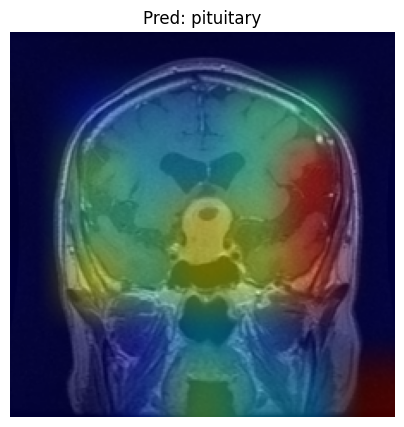

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


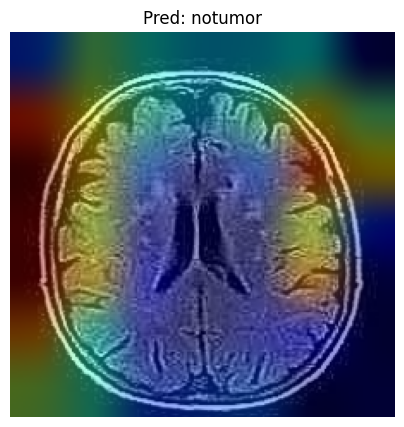

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


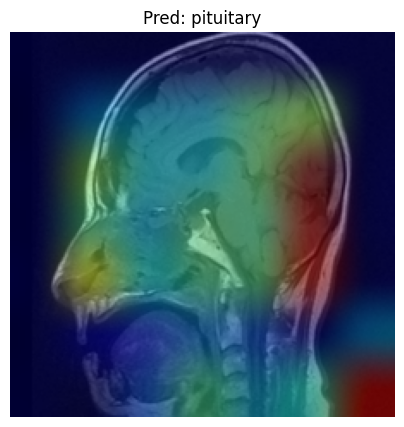

In [26]:
import tensorflow as tf
import numpy as np
import matplotlib.cm as cm
from PIL import Image

# last conv layer bul
last_conv = None
for layer in reversed(base_model.layers):
    if isinstance(layer, tf.keras.layers.Conv2D):
        last_conv = layer.name
        break
print("Last conv layer:", last_conv)

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(last_conv_layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]
    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0,1,2))
    conv_outputs = conv_outputs[0]
    # tensordot ile daha güvenli matmul
    heatmap = tf.tensordot(conv_outputs, pooled_grads, axes=1)
    heatmap = tf.squeeze(heatmap)
    heatmap = tf.maximum(heatmap, 0) / (tf.math.reduce_max(heatmap) + 1e-8)
    return heatmap.numpy()

def show_gradcam_on_image(img_path):
    img = Image.open(img_path).convert('RGB').resize((IMG_SIZE,IMG_SIZE))
    img_array = np.array(img)/255.0
    input_arr = np.expand_dims(img_array, axis=0)
    preds = model.predict(input_arr)
    pred_class = np.argmax(preds[0])
    heatmap = make_gradcam_heatmap(input_arr, model, last_conv, pred_index=pred_class)
    heatmap = np.uint8(255 * heatmap)
    jet = cm.get_cmap("jet")
    jet_colors = jet(np.arange(256))[:,:3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = Image.fromarray((jet_heatmap*255).astype("uint8")).resize(img.size)
    superimposed = Image.blend(img, jet_heatmap, alpha=0.4)
    plt.figure(figsize=(5,5))
    plt.imshow(superimposed)
    plt.title(f"Pred: {label_map[pred_class]}")
    plt.axis('off')
    plt.show()

# testten 3 örnek göster
for i in range(3):
    sample_path = test_df.sample(1, random_state=SEED+i)['filepath'].values[0]
    show_gradcam_on_image(sample_path)

### 15. Modeli Kaydetme
Eğitilmiş modeli `.h5` formatında kaydediyoruz. Böylece tekrar eğitmeden başka ortamlarda kullanabiliriz.

In [27]:
model.save('final_model.h5')
print("Model kaydedildi: final_model.h5")

Model kaydedildi: final_model.h5


### Ek Veri Analizi (EDA)
Bu bölümde sınıf dağılımlarını ve örnek görüntüleri görselleştiriyoruz.Amaç: Veri setini tanımak, dengesizlik olup olmadığını görmek.

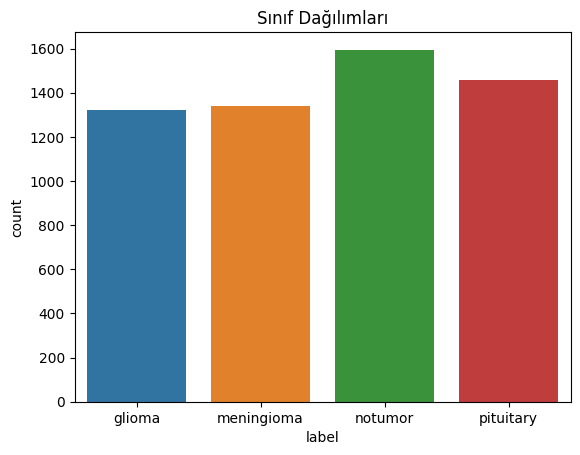

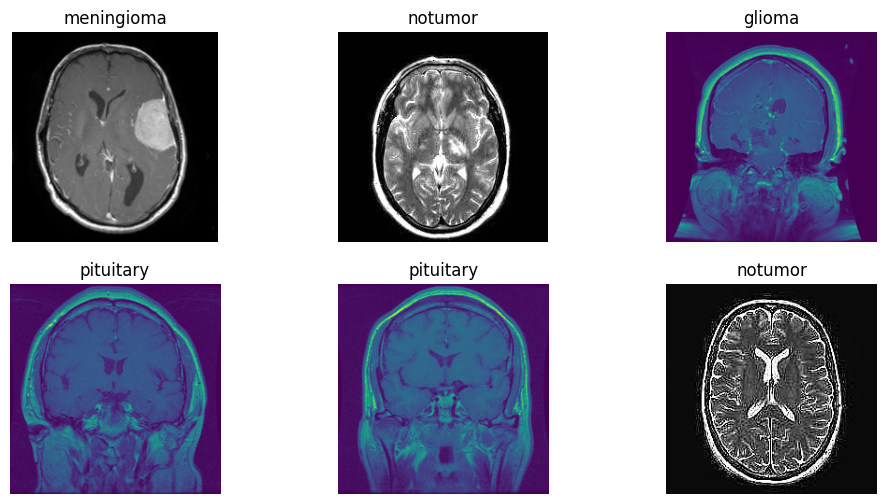

In [28]:
sns.countplot(x='label', data=df)
plt.title("Sınıf Dağılımları")
plt.show()

# örnek görseller
import matplotlib.image as mpimg
sample_df = df.sample(6, random_state=SEED)
plt.figure(figsize=(12,6))
for i, (fp, lbl) in enumerate(zip(sample_df['filepath'], sample_df['label'])):
    plt.subplot(2,3,i+1)
    img = mpimg.imread(fp)
    plt.imshow(img)
    plt.title(lbl)
    plt.axis('off')
plt.show()

### Hiperparametre Denemeleri
Bu bölümde dropout oranı ve batch size değerlerini değiştirerek farklı modeller deniyoruz. Amaç: hangi parametrelerin performansı artırdığını görmek.

SONUÇ: Dropout hiperparametresinde 0.3 ve 0.5 değerleri denendi.
Kısa süreli eğitimde (3 epoch) her iki model de yaklaşık %28 doğrulama doğruluğu elde etti.
Bu, rastgele tahminin (%25) biraz üzerinde olsa da, epoch sayısı artırıldığında ve fine-tuning uygulandığında doğruluğun yükselmesi beklenmektedir.

In [29]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

def build_model(dropout_rate=0.3, lr=1e-4):
    base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE,IMG_SIZE,3))
    base_model.trainable = False
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs=base_model.input, outputs=outputs)
    model.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# dropout=0.3 denemesi
model_d03 = build_model(dropout_rate=0.3)
history_d03 = model_d03.fit(train_gen, validation_data=val_gen, epochs=3, verbose=1)

# dropout=0.5 denemesi
model_d05 = build_model(dropout_rate=0.5)
history_d05 = model_d05.fit(train_gen, validation_data=val_gen, epochs=3, verbose=1)


acc_d03 = max(history_d03.history['val_accuracy'])
acc_d05 = max(history_d05.history['val_accuracy'])

print("Dropout=0.3 -> En iyi val_accuracy:", acc_d03)
print("Dropout=0.5 -> En iyi val_accuracy:", acc_d05)

Epoch 1/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 103s 301ms/step - accuracy: 0.2543 - loss: 1.4026 - val_accuracy: 0.2567 - val_loss: 1.3844
Epoch 2/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 54s 214ms/step - accuracy: 0.2549 - loss: 1.3962 - val_accuracy: 0.2789 - val_loss: 1.3870
Epoch 3/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 54s 214ms/step - accuracy: 0.2811 - loss: 1.3824 - val_accuracy: 0.2789 - val_loss: 1.3826
Epoch 1/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 103s 302ms/step - accuracy: 0.2609 - loss: 1.4061 - val_accuracy: 0.2789 - val_loss: 1.3846
Epoch 2/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 54s 215ms/step - accuracy: 0.2702 - loss: 1.3950 - val_accuracy: 0.2789 - val_loss: 1.3817
Epoch 3/3
250/250 ━━━━━━━━━━━━━━━━━━━━ 54s 215ms/step - accuracy: 0.2751 - loss: 1.3865 - val_accuracy: 0.2835 - val_loss: 1.3802
Dropout=0.3 -> En iyi val_accuracy: 0.2788798213005066
Dropout=0.5 -> En iyi val_accuracy: 0.2835472524166107
